## Importing modules

In [1]:
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt
from gseapy.parser import Biomart
import os
import numpy as np
import seaborn as sns
from gseapy.plot import gseaplot
import fnmatch

In [2]:
def ConvertPairsToMatrix_SN(bayesian_metabol_df):
    bayesian_metabol_df.set_axis(['Gene1','Gene2','weight'], axis=1,inplace=True)
    a = np.unique(bayesian_metabol_df['Gene1'])
    b = np.unique(bayesian_metabol_df['Gene2'])
    c = np.union1d(a,b);
    data = np.zeros((len(c), len(c)));
    output_df = pd.DataFrame(data, index=c, columns=c)
    for values in bayesian_metabol_df.values: 
        output_df[values[0]][values[1]] = values[2];
        output_df[values[1]][values[0]]=values[2];
    np.fill_diagonal(output_df.values,1)
    return output_df

# Converts Wormbase IDs to gene IDs


In [3]:
def wb_to_gene(matrix):
    mapper_df=pd.read_csv("/data/nandas/WormBase_282/MasterProteinCodingGenesAnnotation_WS282.csv", 
                          header='infer',index_col=1)
    mapper_df=mapper_df.loc[mapper_df.index.dropna()]
    wb_to_gene = {};
    for wb in mapper_df.index:
        wb_to_gene[wb] = str(mapper_df.loc[wb]['GeneName']);
    matrix=matrix.rename(index=wb_to_gene,columns=wb_to_gene)
    return matrix

def gene_to_wb(matrix):
    mapper_df=pd.read_csv("/data/nandas/WormBase_282/MasterProteinCodingGenesAnnotation_WS282.csv",
                          header='infer',index_col=2)
    mapper_df=mapper_df.loc[mapper_df.index.dropna()]
    gene_to_wb = {};
    for gene in mapper_df.index:
        gene_to_wb[gene] = str(mapper_df.loc[gene]['WormBaseID']);
    matrix=matrix.rename(index=gene_to_wb,columns=gene_to_wb)
    return matrix

def SeqToWB(output_df):
    mapper_df=pd.read_csv("/data/nandas/WormBase_282/MasterProteinCodingGenesAnnotation_WS282.csv",
                          header='infer',index_col=3)
    mapper_df=mapper_df.loc[mapper_df.index.dropna()]
    Seq_to_Wb = {};
    mapper_df=mapper_df[mapper_df.index!=np.nan]
    for seq in mapper_df.index:
        Seq_to_Wb[seq] = str(mapper_df.loc[seq]['WormBaseID']);
    matrix=matrix.rename(index=Seq_to_Wb,columns=Seq_to_Wb)
    return matrix

def SeqToGene(matrix):
    mapper_df=pd.read_csv("/data/nandas/WormBase_282/MasterProteinCodingGenesAnnotation_WS282.csv", 
                          header='infer',index_col=3)
    mapper_df=mapper_df.loc[mapper_df.index.dropna()]
    Seq_to_Gene = {};
    mapper_df=mapper_df[mapper_df.index!=np.nan]
    for seq in mapper_df.index:
        Seq_to_Gene[seq] = str(mapper_df.loc[seq]['GeneName']);
    matrix=matrix.rename(index=Seq_to_Gene,columns=Seq_to_Gene)
    return matrix

def GeneToSeq(matrix):
    mapper_df=pd.read_csv("/data/nandas/WormBase_282/MasterProteinCodingGenesAnnotation_WS282.csv", 
                          header='infer',
                          index_col=2)
    mapper_df=mapper_df.loc[mapper_df.index.dropna()]
    Gene_to_Seq = {};
    mapper_df=mapper_df[mapper_df.index!=np.nan]
    for gene in mapper_df.index:
        Gene_to_Seq[gene] = str(mapper_df.loc[gene]['SequenceID']);
    matrix=matrix.rename(index=Gene_to_Seq,columns=Gene_to_Seq)
    return matrix

def PreRank(genes, outdir,gene_sets):
#     print("Genes: {}".format(genes));
    print("Length of genes:{}".format(len(genes)))
    genes=pd.DataFrame(genes)
    genes.set_index([0],inplace=True)
    genes=SeqToGene(genes)
    genes=list(genes.index)
    intersection_list = list(set(metabolic_corr_df.index).intersection(set(genes)))
#     print("intersection_list:{}".format(intersection_list))
    missing_genes=list(set(genes).difference(set(intersection_list)))
#     print("IntersectionList: {}".format(intersection_list));
#     print("Length of intersection list:{}".format(len(intersection_list)))
#     print('Missing genes:{}\n{}'.format(len(missing_genes),missing_genes))
    if(len(missing_genes) == len(genes)):
        return;
    Combined=metabolic_corr_df[intersection_list];
    Mean=Combined.mean(axis=1)
#    print("Mean before scaling:{}".format(Mean))
#     Mean=(Mean*2)-1
#     print("Mean after scaling to lie between -1 and +1:{}".format(Mean))
    Mean.dropna(inplace=True)
    rnk=Mean.sort_values(ascending=False)
    plt.rcParams["font.family"] = "Arial"
#     print("Rank: {}".format(rnk))    
    pre_res = gp.prerank(rnk=rnk, gene_sets=gene_sets, processes=4,min_size=2, outdir=outdir, format='svg', 
                         weighted_score_type=1,verbose=True)
    plt.close()
    return pre_res

def _is_regulated_pathway_(pre_res, pathway):
#     print('Hello There: {}'.format(pre_res));
#     print('Shivani Here: {}'.format(pre_res.res2d))
    if(pathway not in pre_res.res2d.index):
        return "NaN"
    else:
        pathway_pre_res = pre_res.res2d.loc[pathway];
#     is_regulated_pathway = pathway_pre_res.es >= 0.70 and pathway_pre_res.fdr <= 0.05
        is_regulated_pathway =  (pathway_pre_res.fdr <= 0.05) and (pathway_pre_res.nes>0) and (pathway_pre_res.nes!=np.inf) and (pathway_pre_res.es>0)
    return is_regulated_pathway;

def PlotEnrichment(pre_res,pathway, outdir):
    Sorted_values=pre_res.res2d.sort_values(ascending=False,by=['nes'])[0:40]
    fig = plt.figure(figsize=(8,15))
    df = pd.DataFrame({'Enrichment Score': Sorted_values.es,
                   'p-value': Sorted_values.pval,'FDR':Sorted_values.fdr}, index=Sorted_values.index)
    ax = df.plot.barh(rot=0)
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    plt.rcParams["font.family"] = "Arial"
    plt.savefig("{}/{}_plot.svg".format(outdir, pathway))
    plt.show()
    plt.close()
    
def PlotGSEA(pre_res, pathway, outdir,term):
    terms = pre_res.res2d.sort_values(by=['es'],ascending=False).index
#     print(terms[17])
    print("term is: {}".format(term))
    fig=gseaplot(rank_metric=pre_res.ranking,term=term, **pre_res.results[term],ofname='{}/{}_gsea.svg'.format(outdir,term))
    plt.show()
    

In [4]:
# ! mkdir /data/nandas/Coflux_matrix/FluxRed_102220/Product_Matrix_041122_4_4/


## Setting base directory

In [5]:
Base_dir='/data/nandas/Coflux_matrix/FluxRed_102220/Product_Matrix_062122/'
output_dir='/data/nandas/Coflux_matrix/FluxRed_102220/Product_Matrix_062122/'
os.chdir(Base_dir)

In [6]:
MetabolicPairs=pd.read_csv("/data/nandas/Combined_coexp/MetabolicCorrPairs_062321.dat",
                           sep='\t',header=None)

In [7]:
# !mkdir /data/nandas/Combined_coexp/Pathway_enrichment/NewSets_090420/OverallPathwayEnrichment062421/

In [8]:
# metabolic_corr_df=ConvertPairsToMatrix_SN(MetabolicPairs)

## Reading required files: GeneSets(gmt), PathwayToGenes and Gene Correlations 

In [9]:
# pathway_filename1 = '/data/nandas/Combined_coexp/Pathway_enrichment/NewSets_090420/Genesets_NAME_090320_LEVEL_1.gmt';
# pathway_filename2 = '/data/nandas/Combined_coexp/Pathway_enrichment/NewSets_090420/Genesets_NAME_090320_LEVEL_2.gmt';
# pathway_filename3 = '/data/nandas/Combined_coexp/Pathway_enrichment/NewSets_090420/Genesets_NAME_090320_LEVEL_3.gmt';
# # pathway_filename4 = '/data/nandas/Combined_coexp/Pathway_enrichment/NewSets_090420/Genesets_NAME_090320_LEVEL_4.gmt';
# # metabolic_corr_df=pd.read_csv("/data/nandas/Combined_coexp/Sleipnir/Final_data_080620/UMN/MetabolicCorrMatrix_083120.csv",index_col=0,header='infer')
# Pathway_df1=pd.read_csv(pathway_filename1,index_col=0,sep='\t')
# Pathway_df2=pd.read_csv(pathway_filename2,index_col=0,sep='\t')
# Pathway_df3=pd.read_csv(pathway_filename3,index_col=0,sep='\t')
# # Pathway_df4=pd.read_csv(pathway_filename4,index_col=0,sep='\t')

In [10]:
pathway_filename4="/data/nandas/Coflux_matrix/FluxRed_102220/Product_Matrix_062122/ProductMatrix_SelectedClusterSets_062722_3_2.gmt"
Pathway_df4=pd.read_csv(pathway_filename4,sep='\t',index_col=0)

In [11]:
# for i in Pathway_df4.columns:
#     Pathway_df4.rename(columns={'{}'.format(i):'Gene{}'.format(i)},inplace=True)

In [12]:
Pathway_df4.dropna(axis=1,how='all',inplace=True)

In [13]:
Pathway_df4

,Mean Silhoutte Values,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,Gene_10,Gene_11,Gene_12,Gene_13,Gene_14,Gene_15,Gene_16,Gene_17,Gene_18
ClusterName,,,,,,,,,,,,,,,,,,,
Cluster_1,0.483769,nduo-6,nduo-2,ndfl-4,nduo-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_2,0.454617,daf-18,aap-1,age-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_3,0.389896,got-2.2,mdh-1,mdh-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_4,0.376646,pgph-1,F41E6.5,pgph-2,pgph-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_5,0.367885,unc-32,vha-11,vha-4,vha-15,vha-2,vha-10,vha-3,vha-9,vha-1,vha-12,vha-8,vha-14,vha-19,vha-17,vha-6,vha-5,vha-13,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cluster_95,0.102297,ampd-1,pnp-1,adss-1,adah-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_96,0.100785,thk-1,upp-1,dhfr-1,tyms-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_97,0.099894,gln-3,asns-1,asns-2,C05C8.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Pathway_df4=Pathway_df4[['Mean Silhouette Values','Gene0', 'Gene1', 'Gene2', 'Gene3', 'Gene4', 'Gene5', 'Gene6', 'Gene7',
#        'Gene8', 'Gene9', 'Gene10', 'Gene11', 'Gene12', 'Gene13', 'Gene14',
#        'Gene15', 'Gene16', 'Gene17',
#        'GeneIsRegulated']]

In [15]:
# for i in Pathway_df4.index:
#     Pathway_df4.at[i,'ClusterNumber']="Cluster_{}".format(i)
    

In [16]:
# Pathway_df4.set_index(['ClusterNumber'],inplace=True)

In [13]:
Pathway_df4

,Mean Silhoutte Values,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,Gene_10,Gene_11,Gene_12,Gene_13,Gene_14,Gene_15,Gene_16,Gene_17,Gene_18
ClusterName,,,,,,,,,,,,,,,,,,,
Cluster_1,0.483769,nduo-6,nduo-2,ndfl-4,nduo-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_2,0.454617,daf-18,aap-1,age-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_3,0.389896,got-2.2,mdh-1,mdh-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_4,0.376646,pgph-1,F41E6.5,pgph-2,pgph-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_5,0.367885,unc-32,vha-11,vha-4,vha-15,vha-2,vha-10,vha-3,vha-9,vha-1,vha-12,vha-8,vha-14,vha-19,vha-17,vha-6,vha-5,vha-13,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cluster_95,0.102297,ampd-1,pnp-1,adss-1,adah-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_96,0.100785,thk-1,upp-1,dhfr-1,tyms-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_97,0.099894,gln-3,asns-1,asns-2,C05C8.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# for i in Pathway_df4.index:
#     print(i)
#     Pathway_df4=Pathway_df4.rename(index={'{}'.format(i):'Cluster{}'.format(i)})

In [14]:
Pathway_df4

,Mean Silhoutte Values,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,Gene_10,Gene_11,Gene_12,Gene_13,Gene_14,Gene_15,Gene_16,Gene_17,Gene_18
ClusterName,,,,,,,,,,,,,,,,,,,
Cluster_1,0.483769,nduo-6,nduo-2,ndfl-4,nduo-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_2,0.454617,daf-18,aap-1,age-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_3,0.389896,got-2.2,mdh-1,mdh-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_4,0.376646,pgph-1,F41E6.5,pgph-2,pgph-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_5,0.367885,unc-32,vha-11,vha-4,vha-15,vha-2,vha-10,vha-3,vha-9,vha-1,vha-12,vha-8,vha-14,vha-19,vha-17,vha-6,vha-5,vha-13,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cluster_95,0.102297,ampd-1,pnp-1,adss-1,adah-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_96,0.100785,thk-1,upp-1,dhfr-1,tyms-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_97,0.099894,gln-3,asns-1,asns-2,C05C8.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# metabolic_corr_df.to_csv("MetabolicCorrMatrix_021921.csv")

In [15]:
metabolic_corr_df=pd.read_csv("/data/nandas/Combined_coexp/Pathway_enrichment/NewSets_090420/OrphanGenes/MetabolicCorrMatrix062321.csv",
                              index_col=0)

In [16]:
## To ignore self-correlations, remove diagonals of correlation matrix
np.fill_diagonal(metabolic_corr_df.values,np.nan)

In [17]:
metabolic_corr_df.min().min()

-0.36478

In [18]:
metabolic_corr_df.shape

(2505, 2505)

In [19]:
metabolic_corr_df=wb_to_gene(metabolic_corr_df)

In [20]:
metabolic_corr_df.to_csv("MetabolicCorrMatrix_GeneID_062822.csv")

In [27]:
# metabolic_corr_df=(metabolic_corr_df+1)/2

In [28]:
# metabolic_corr_df.min().min()

In [21]:
metabolic_corr_df['haly-1'].sort_values(ascending=False)[0:20]

Y51H4A.7     0.597110
pah-1        0.528318
F55A11.6     0.485382
hpd-1        0.453570
bus-8        0.447316
Y38C1AB.1    0.446178
vha-5        0.438398
sams-1       0.437492
ads-1        0.420730
dpyd-1       0.419898
K07E3.4      0.416554
F08F3.4      0.412088
faah-1       0.412026
argn-1       0.408304
aass-1       0.406326
gyg-1        0.406008
tatn-1       0.405482
ugt-54       0.394044
got-1.2      0.394002
T25B9.1      0.392174
Name: haly-1, dtype: float64

### Setting default coregulated state of pathway

In [22]:
# Pathway_df1['IsRegulated'] = False

# Pathway_df2['IsRegulated'] = False
# Pathway_df3['IsRegulated'] = False
Pathway_df4['IsRegulated'] = False


In [23]:
metabolic_corr_df=metabolic_corr_df[~metabolic_corr_df.index.duplicated(keep='first')]

## PreRank Gene set enrichment analyses for custom pathway annotations

In [24]:
metabolic_corr_df=gene_to_wb(metabolic_corr_df)
metabolic_corr_df=wb_to_gene(metabolic_corr_df)
metabolic_corr_df=SeqToGene(metabolic_corr_df)

In [33]:
# New_df1 = pd.DataFrame([])
# for pathway in Pathway_df1.index:
#     #pathway = 'GLY_CLEAVAGE_SYSTEM';
#     print(pathway)
# #     pathway = 'ALA_ASP_AND_GLU_METABOLISM';
#     genes = list(Pathway_df1_withoutIsRegulated.loc[pathway].dropna());
#     pre_res = PreRank(genes, pathway,gene_sets=pathway_filename1);
#     if(pre_res is None):
#         continue; 
#     Pathway_df1.at[pathway, 'IsRegulated'] = _is_regulated_pathway_(pre_res, pathway);
#     print("{} is regulated:{}".format(pathway,_is_regulated_pathway_(pre_res, pathway)))
#     PlotEnrichment(pre_res, pathway, outdir=pathway)
#     if(pathway in pre_res.res2d.index):
#         PlotGSEA(pre_res, pathway,pathway)
#         gsea_result_df=pre_res.res2d.loc[pathway];
#         New_df1=New_df1.append(gsea_result_df)
# # Pathway_df1.to_csv("Pathway_Regulation_status1.csv")
# New_df1.to_csv("Final_pathway1_gsea.csv")




In [34]:
# New_df2 = pd.DataFrame([])
# for pathway in Pathway_df2.index:
#     #pathway = 'GLY_CLEAVAGE_SYSTEM';
#     print(pathway)
# #     pathway = 'ALA_ASP_AND_GLU_METABOLISM';
#     genes = list(Pathway_df2_withoutIsRegulated.loc[pathway].dropna());
#     pre_res = PreRank(genes, pathway,gene_sets=pathway_filename2);
#     if(pre_res is None):
#         continue; 
#     Pathway_df2.at[pathway, 'IsRegulated'] = _is_regulated_pathway_(pre_res, pathway);
#     print("{} is regulated:{}".format(pathway,_is_regulated_pathway_(pre_res, pathway)))
#     PlotEnrichment(pre_res, pathway, outdir=pathway)
#     if(pathway in pre_res.res2d.index):
#         PlotGSEA(pre_res, pathway,pathway)
#         gsea_result_df=pre_res.res2d.loc[pathway];
#         New_df2=New_df2.append(gsea_result_df)
# # Pathway_df2.to_csv("Pathway_Regulation_status2.csv")
# New_df2.to_csv("Final_pathway2_gsea.csv")


In [35]:
# New_df3 = pd.DataFrame([])
# for pathway in Pathway_df3.index:
#     #pathway = 'GLY_CLEAVAGE_SYSTEM';
#     print(pathway)
# #     pathway = 'ALA_ASP_AND_GLU_METABOLISM';
#     genes = list(Pathway_df3_withoutIsRegulated.loc[pathway].dropna());
#     pre_res = PreRank(genes, pathway,gene_sets=pathway_filename3);
#     if(pre_res is None):
#         continue; 
#     Pathway_df3.at[pathway, 'IsRegulated'] = _is_regulated_pathway_(pre_res, pathway);
#     print("{} is regulated:{}".format(pathway,_is_regulated_pathway_(pre_res, pathway)))
#     PlotEnrichment(pre_res, pathway, outdir=pathway)
#     if(pathway in pre_res.res2d.index):
#         PlotGSEA(pre_res, pathway,pathway)
#         gsea_result_df=pre_res.res2d.loc[pathway];
#         New_df3=New_df3.append(gsea_result_df)
# # Pathway_df3.to_csv("Pathway_Regulation_status3.csv")
# New_df3.to_csv("Final_pathway3_gsea.csv")

In [35]:
Pathway_df4

,Mean Silhoutte Values,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,...,Gene_29,Gene_30,Gene_31,Gene_32,Gene_33,Gene_34,Gene_35,Gene_36,Gene_37,Gene_38
ClusterName,,,,,,,,,,,,,,,,,,,,,
Cluster_1,0.483769,nduo-6,nduo-2,ndfl-4,nduo-3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_2,0.454617,daf-18,aap-1,age-1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_3,0.389896,got-2.2,mdh-1,mdh-2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_4,0.376646,pgph-1,F41E6.5,pgph-2,pgph-3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_5,0.367885,unc-32,vha-11,vha-4,vha-15,vha-2,vha-10,vha-3,vha-9,vha-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cluster_95,0.102297,ampd-1,pnp-1,adss-1,adah-1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_96,0.100785,thk-1,upp-1,dhfr-1,tyms-1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_97,0.099894,gln-3,asns-1,asns-2,C05C8.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# !mkdir /data/nandas/Combined_coexp/Pathway_enrichment/NewSets_090420/ClusterSetsEnrichment_070721/

In [26]:
Pathway_df4.drop(columns=['Mean Silhoutte Values'],inplace=True)

In [36]:
Pathway_df4[0:20]

,Mean Silhoutte Values,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,...,Gene_29,Gene_30,Gene_31,Gene_32,Gene_33,Gene_34,Gene_35,Gene_36,Gene_37,Gene_38
ClusterName,,,,,,,,,,,,,,,,,,,,,
Cluster_1,0.483769,nduo-6,nduo-2,ndfl-4,nduo-3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_2,0.454617,daf-18,aap-1,age-1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_3,0.389896,got-2.2,mdh-1,mdh-2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_4,0.376646,pgph-1,F41E6.5,pgph-2,pgph-3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_5,0.367885,unc-32,vha-11,vha-4,vha-15,vha-2,vha-10,vha-3,vha-9,vha-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_6,0.360943,dlat-1,pdha-1,dld-1,pdhb-1,dlat-2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_7,0.358675,hgo-1,hpd-1,fah-1,gst-43,gst-42,Y53G8B.1,C31H2.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_8,0.356639,cpin-1,haly-1,amdh-1,Y51H4A.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_9,0.322974,parp-1,parg-1,parp-2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Pathway_df1_withoutIsRegulated = Pathway_df1.drop(['IsRegulated'], axis=1);
# Pathway_df2_withoutIsRegulated = Pathway_df2.drop(['IsRegulated'], axis=1);
# Pathway_df3_withoutIsRegulated = Pathway_df3.drop(['IsRegulated'], axis=1);
# Pathway_df4_withoutIsRegulated = Pathway_df4.drop(['IsRegulated'], axis=1);

In [41]:
# genes = list(Pathway_df4.loc[pathway].dropna());

In [37]:
Pathway_df4

,Mean Silhoutte Values,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,...,Gene_29,Gene_30,Gene_31,Gene_32,Gene_33,Gene_34,Gene_35,Gene_36,Gene_37,Gene_38
ClusterName,,,,,,,,,,,,,,,,,,,,,
Cluster_1,0.483769,nduo-6,nduo-2,ndfl-4,nduo-3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_2,0.454617,daf-18,aap-1,age-1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_3,0.389896,got-2.2,mdh-1,mdh-2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_4,0.376646,pgph-1,F41E6.5,pgph-2,pgph-3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_5,0.367885,unc-32,vha-11,vha-4,vha-15,vha-2,vha-10,vha-3,vha-9,vha-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cluster_95,0.102297,ampd-1,pnp-1,adss-1,adah-1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_96,0.100785,thk-1,upp-1,dhfr-1,tyms-1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster_97,0.099894,gln-3,asns-1,asns-2,C05C8.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Cluster_1
Length of genes:5


2022-06-29 03:17:01,602 Parsing data files for GSEA.............................
2022-06-29 03:17:01,651 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:17:01,653 0099 gene_sets used for further statistical testing.....
2022-06-29 03:17:01,655 Start to run GSEA...Might take a while..................
2022-06-29 03:17:16,840 Start to generate gseapy reports, and produce figures...
2022-06-29 03:17:34,871 Congratulations. GSEApy runs successfully................



Cluster_1 is regulated:True


<Figure size 576x1080 with 0 Axes>

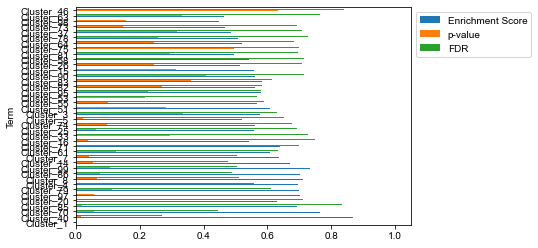

term is: Cluster_1
Cluster_2
Length of genes:4


2022-06-29 03:18:32,567 Parsing data files for GSEA.............................
2022-06-29 03:18:32,647 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:18:32,649 0099 gene_sets used for further statistical testing.....
2022-06-29 03:18:32,653 Start to run GSEA...Might take a while..................
2022-06-29 03:18:37,938 Start to generate gseapy reports, and produce figures...
2022-06-29 03:18:54,982 Congratulations. GSEApy runs successfully................



Cluster_2 is regulated:True


<Figure size 576x1080 with 0 Axes>

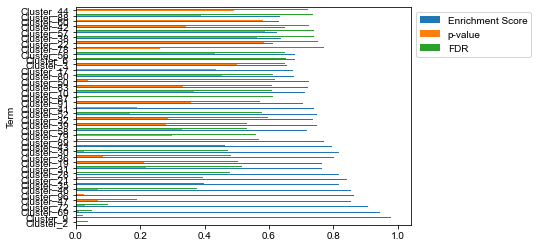

term is: Cluster_2
Cluster_3
File: Pathway_self_enrichment_Cluster_3.csv found, skipping!!!
Cluster_4
Length of genes:5


2022-06-29 03:19:56,138 Parsing data files for GSEA.............................
2022-06-29 03:19:56,185 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:19:56,187 0099 gene_sets used for further statistical testing.....
2022-06-29 03:19:56,189 Start to run GSEA...Might take a while..................
2022-06-29 03:20:01,526 Start to generate gseapy reports, and produce figures...
2022-06-29 03:20:20,636 Congratulations. GSEApy runs successfully................



Cluster_4 is regulated:True


<Figure size 576x1080 with 0 Axes>

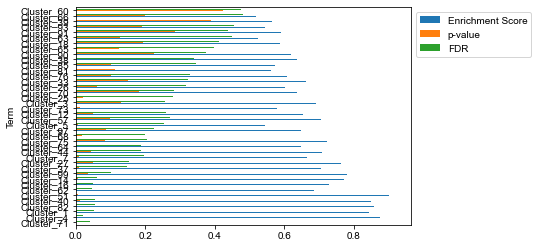

term is: Cluster_4
Cluster_5
Length of genes:18


2022-06-29 03:21:23,019 Parsing data files for GSEA.............................
2022-06-29 03:21:23,069 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:21:23,071 0099 gene_sets used for further statistical testing.....
2022-06-29 03:21:23,073 Start to run GSEA...Might take a while..................
2022-06-29 03:21:28,817 Start to generate gseapy reports, and produce figures...
2022-06-29 03:21:48,077 Congratulations. GSEApy runs successfully................



Cluster_5 is regulated:True


<Figure size 576x1080 with 0 Axes>

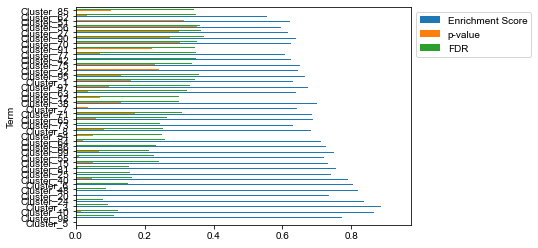

term is: Cluster_5
Cluster_6
Length of genes:6


2022-06-29 03:22:45,221 Parsing data files for GSEA.............................
2022-06-29 03:22:45,300 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:22:45,303 0099 gene_sets used for further statistical testing.....
2022-06-29 03:22:45,305 Start to run GSEA...Might take a while..................
2022-06-29 03:22:52,380 Start to generate gseapy reports, and produce figures...
2022-06-29 03:23:11,371 Congratulations. GSEApy runs successfully................



Cluster_6 is regulated:True


<Figure size 576x1080 with 0 Axes>

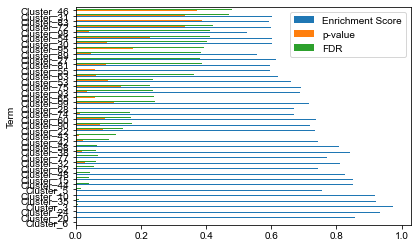

term is: Cluster_6
Cluster_7
File: Pathway_self_enrichment_Cluster_7.csv found, skipping!!!
Cluster_8
File: Pathway_self_enrichment_Cluster_8.csv found, skipping!!!
Cluster_9
Length of genes:4


2022-06-29 03:24:12,802 Parsing data files for GSEA.............................
2022-06-29 03:24:12,883 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:24:12,885 0099 gene_sets used for further statistical testing.....
2022-06-29 03:24:12,887 Start to run GSEA...Might take a while..................
2022-06-29 03:24:18,346 Start to generate gseapy reports, and produce figures...
2022-06-29 03:24:37,681 Congratulations. GSEApy runs successfully................



Cluster_9 is regulated:True


<Figure size 576x1080 with 0 Axes>

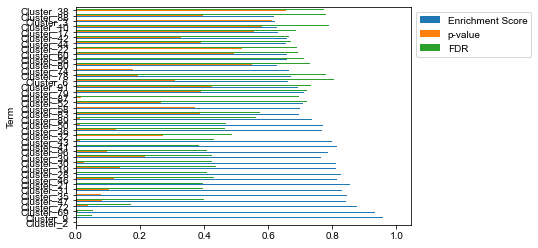

term is: Cluster_9
Cluster_10
Length of genes:4


2022-06-29 03:25:38,537 Parsing data files for GSEA.............................
2022-06-29 03:25:38,620 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:25:38,623 0099 gene_sets used for further statistical testing.....
2022-06-29 03:25:38,625 Start to run GSEA...Might take a while..................
2022-06-29 03:25:44,733 Start to generate gseapy reports, and produce figures...
2022-06-29 03:26:01,634 Congratulations. GSEApy runs successfully................



Cluster_10 is regulated:True


<Figure size 576x1080 with 0 Axes>

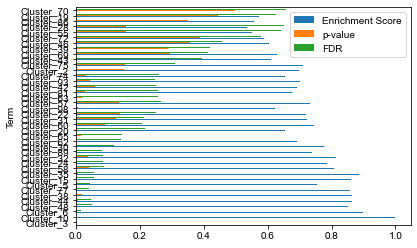

term is: Cluster_10
Cluster_11
Length of genes:4


2022-06-29 03:27:00,155 Parsing data files for GSEA.............................
2022-06-29 03:27:00,204 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:27:00,206 0099 gene_sets used for further statistical testing.....
2022-06-29 03:27:00,208 Start to run GSEA...Might take a while..................
2022-06-29 03:27:05,347 Start to generate gseapy reports, and produce figures...
2022-06-29 03:27:22,372 Congratulations. GSEApy runs successfully................



Cluster_11 is regulated:True


<Figure size 576x1080 with 0 Axes>

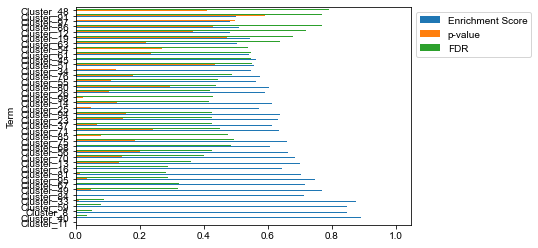

term is: Cluster_11
Cluster_12
Length of genes:6


2022-06-29 03:28:19,796 Parsing data files for GSEA.............................
2022-06-29 03:28:19,876 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:28:19,879 0099 gene_sets used for further statistical testing.....
2022-06-29 03:28:19,881 Start to run GSEA...Might take a while..................
2022-06-29 03:28:25,153 Start to generate gseapy reports, and produce figures...
2022-06-29 03:28:42,008 Congratulations. GSEApy runs successfully................



Cluster_12 is regulated:True


<Figure size 576x1080 with 0 Axes>

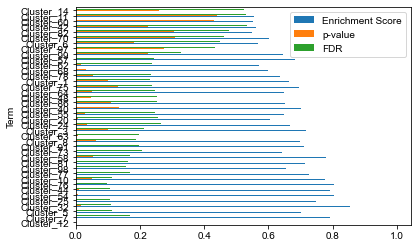

term is: Cluster_12
Cluster_13
Length of genes:4


2022-06-29 03:29:42,227 Parsing data files for GSEA.............................
2022-06-29 03:29:42,280 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:29:42,282 0099 gene_sets used for further statistical testing.....
2022-06-29 03:29:42,285 Start to run GSEA...Might take a while..................
2022-06-29 03:29:47,385 Start to generate gseapy reports, and produce figures...
2022-06-29 03:30:05,630 Congratulations. GSEApy runs successfully................



Cluster_13 is regulated:True


<Figure size 576x1080 with 0 Axes>

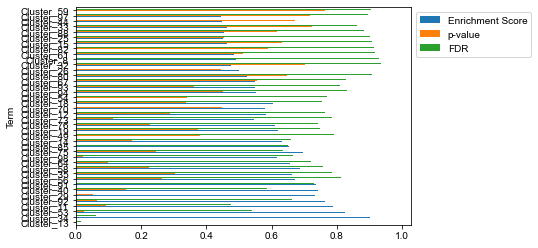

term is: Cluster_13
Cluster_14
Length of genes:6


2022-06-29 03:31:07,610 Parsing data files for GSEA.............................
2022-06-29 03:31:07,661 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:31:07,663 0099 gene_sets used for further statistical testing.....
2022-06-29 03:31:07,665 Start to run GSEA...Might take a while..................
2022-06-29 03:31:13,058 Start to generate gseapy reports, and produce figures...
2022-06-29 03:31:29,437 Congratulations. GSEApy runs successfully................



Cluster_14 is regulated:False


<Figure size 576x1080 with 0 Axes>

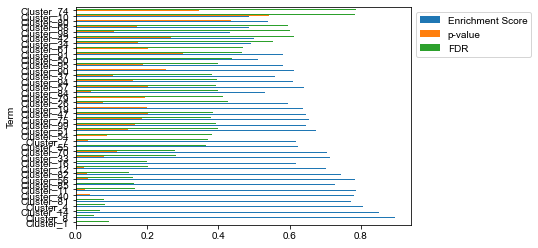

term is: Cluster_14
Cluster_15
Length of genes:5


2022-06-29 03:32:27,916 Parsing data files for GSEA.............................
2022-06-29 03:32:27,996 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:32:27,998 0099 gene_sets used for further statistical testing.....
2022-06-29 03:32:28,000 Start to run GSEA...Might take a while..................
2022-06-29 03:32:33,244 Start to generate gseapy reports, and produce figures...
2022-06-29 03:32:51,401 Congratulations. GSEApy runs successfully................



Cluster_15 is regulated:True


<Figure size 576x1080 with 0 Axes>

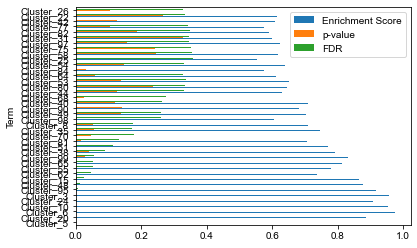

term is: Cluster_15
Cluster_16
Length of genes:13


2022-06-29 03:33:51,149 Parsing data files for GSEA.............................
2022-06-29 03:33:51,213 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:33:51,215 0099 gene_sets used for further statistical testing.....
2022-06-29 03:33:51,218 Start to run GSEA...Might take a while..................
2022-06-29 03:33:56,470 Start to generate gseapy reports, and produce figures...
2022-06-29 03:34:13,278 Congratulations. GSEApy runs successfully................



Cluster_16 is regulated:True


<Figure size 576x1080 with 0 Axes>

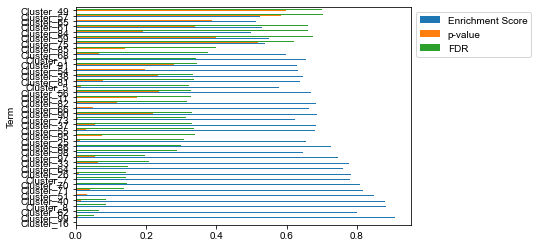

term is: Cluster_16
Cluster_17
Length of genes:4


2022-06-29 03:35:13,690 Parsing data files for GSEA.............................
2022-06-29 03:35:13,750 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:35:13,752 0099 gene_sets used for further statistical testing.....
2022-06-29 03:35:13,753 Start to run GSEA...Might take a while..................
2022-06-29 03:35:19,298 Start to generate gseapy reports, and produce figures...
2022-06-29 03:35:35,084 Congratulations. GSEApy runs successfully................



Cluster_17 is regulated:True


<Figure size 576x1080 with 0 Axes>

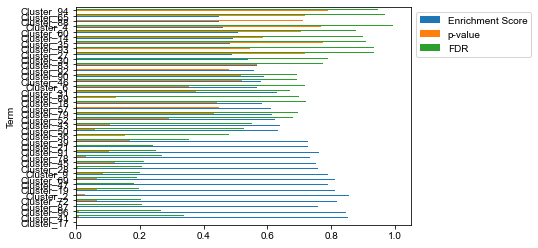

term is: Cluster_17
Cluster_18
Length of genes:5


2022-06-29 03:36:32,489 Parsing data files for GSEA.............................
2022-06-29 03:36:32,570 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:36:32,572 0099 gene_sets used for further statistical testing.....
2022-06-29 03:36:32,574 Start to run GSEA...Might take a while..................
2022-06-29 03:36:37,912 Start to generate gseapy reports, and produce figures...
2022-06-29 03:36:54,565 Congratulations. GSEApy runs successfully................



Cluster_18 is regulated:True


<Figure size 576x1080 with 0 Axes>

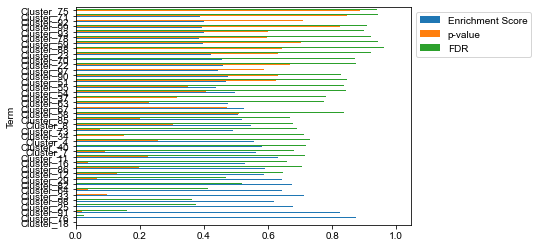

term is: Cluster_18
Cluster_19
Length of genes:4


2022-06-29 03:37:51,703 Parsing data files for GSEA.............................
2022-06-29 03:37:51,751 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:37:51,754 0099 gene_sets used for further statistical testing.....
2022-06-29 03:37:51,757 Start to run GSEA...Might take a while..................
2022-06-29 03:37:56,868 Start to generate gseapy reports, and produce figures...
2022-06-29 03:38:13,774 Congratulations. GSEApy runs successfully................



Cluster_19 is regulated:False


<Figure size 576x1080 with 0 Axes>

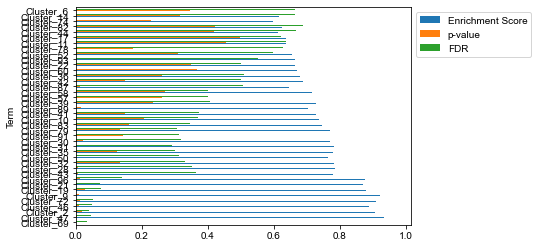

term is: Cluster_19
Cluster_20
Length of genes:14


2022-06-29 03:39:09,776 Parsing data files for GSEA.............................
2022-06-29 03:39:09,855 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:39:09,858 0099 gene_sets used for further statistical testing.....
2022-06-29 03:39:09,861 Start to run GSEA...Might take a while..................
2022-06-29 03:39:15,118 Start to generate gseapy reports, and produce figures...
2022-06-29 03:39:33,312 Congratulations. GSEApy runs successfully................



Cluster_20 is regulated:True


<Figure size 576x1080 with 0 Axes>

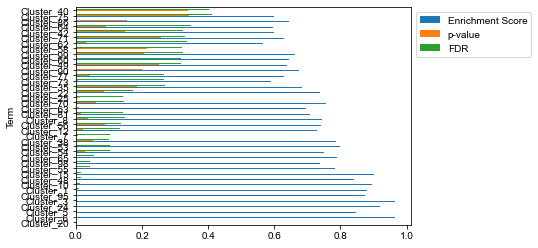

term is: Cluster_20
Cluster_21
Length of genes:7


2022-06-29 03:40:28,877 Parsing data files for GSEA.............................
2022-06-29 03:40:28,960 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:40:28,962 0099 gene_sets used for further statistical testing.....
2022-06-29 03:40:28,964 Start to run GSEA...Might take a while..................
2022-06-29 03:40:34,176 Start to generate gseapy reports, and produce figures...
2022-06-29 03:40:51,314 Congratulations. GSEApy runs successfully................



Cluster_21 is regulated:False


<Figure size 576x1080 with 0 Axes>

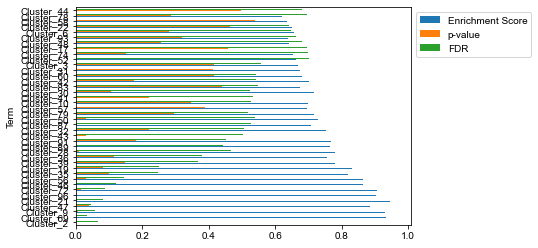

term is: Cluster_21
Cluster_22
Length of genes:4


2022-06-29 03:41:47,421 Parsing data files for GSEA.............................
2022-06-29 03:41:47,472 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:41:47,475 0099 gene_sets used for further statistical testing.....
2022-06-29 03:41:47,478 Start to run GSEA...Might take a while..................
2022-06-29 03:41:52,669 Start to generate gseapy reports, and produce figures...
2022-06-29 03:42:10,517 Congratulations. GSEApy runs successfully................



Cluster_22 is regulated:False


<Figure size 576x1080 with 0 Axes>

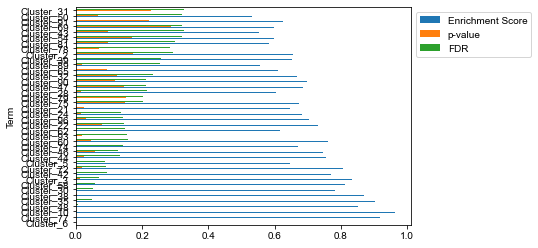

term is: Cluster_22
Cluster_23
Length of genes:5


2022-06-29 03:43:07,212 Parsing data files for GSEA.............................
2022-06-29 03:43:07,262 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:43:07,265 0099 gene_sets used for further statistical testing.....
2022-06-29 03:43:07,268 Start to run GSEA...Might take a while..................
2022-06-29 03:43:12,269 Start to generate gseapy reports, and produce figures...
2022-06-29 03:43:29,268 Congratulations. GSEApy runs successfully................



Cluster_23 is regulated:True


<Figure size 576x1080 with 0 Axes>

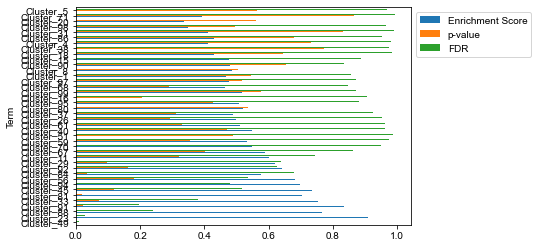

term is: Cluster_23
Cluster_24
Length of genes:7


2022-06-29 03:44:25,275 Parsing data files for GSEA.............................
2022-06-29 03:44:25,356 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:44:25,358 0099 gene_sets used for further statistical testing.....
2022-06-29 03:44:25,360 Start to run GSEA...Might take a while..................
2022-06-29 03:44:30,619 Start to generate gseapy reports, and produce figures...
2022-06-29 03:44:48,400 Congratulations. GSEApy runs successfully................



Cluster_24 is regulated:True


<Figure size 576x1080 with 0 Axes>

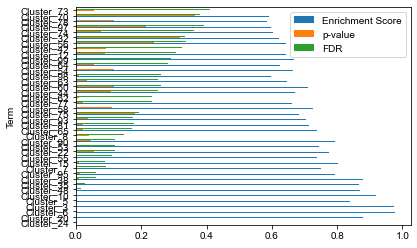

term is: Cluster_24
Cluster_25
Length of genes:10


2022-06-29 03:45:45,160 Parsing data files for GSEA.............................
2022-06-29 03:45:45,208 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:45:45,210 0099 gene_sets used for further statistical testing.....
2022-06-29 03:45:45,212 Start to run GSEA...Might take a while..................
2022-06-29 03:45:50,526 Start to generate gseapy reports, and produce figures...
2022-06-29 03:46:05,966 Congratulations. GSEApy runs successfully................



Cluster_25 is regulated:False


<Figure size 576x1080 with 0 Axes>

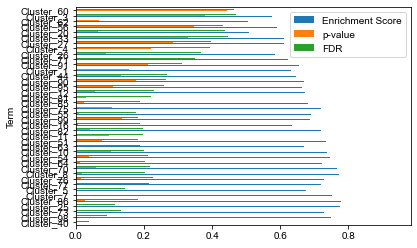

term is: Cluster_25
Cluster_26
Length of genes:7


2022-06-29 03:47:02,535 Parsing data files for GSEA.............................
2022-06-29 03:47:02,585 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:47:02,588 0099 gene_sets used for further statistical testing.....
2022-06-29 03:47:02,590 Start to run GSEA...Might take a while..................
2022-06-29 03:47:08,052 Start to generate gseapy reports, and produce figures...
2022-06-29 03:47:24,040 Congratulations. GSEApy runs successfully................



Cluster_26 is regulated:False


<Figure size 576x1080 with 0 Axes>

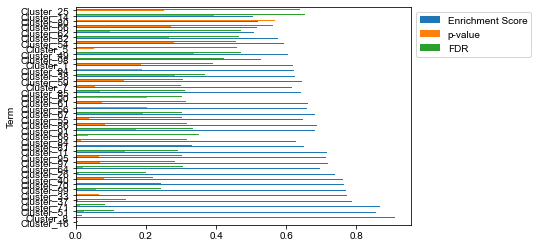

term is: Cluster_26
Cluster_27
Length of genes:4


2022-06-29 03:48:20,834 Parsing data files for GSEA.............................
2022-06-29 03:48:20,883 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:48:20,886 0099 gene_sets used for further statistical testing.....
2022-06-29 03:48:20,888 Start to run GSEA...Might take a while..................
2022-06-29 03:48:26,153 Start to generate gseapy reports, and produce figures...
2022-06-29 03:48:42,106 Congratulations. GSEApy runs successfully................



Cluster_27 is regulated:True


<Figure size 576x1080 with 0 Axes>

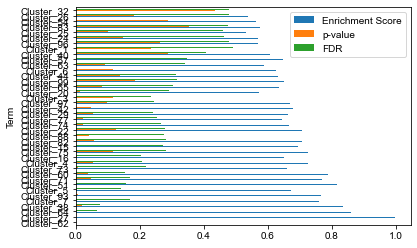

term is: Cluster_27
Cluster_28
Length of genes:9


2022-06-29 03:49:40,355 Parsing data files for GSEA.............................
2022-06-29 03:49:40,406 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:49:40,409 0099 gene_sets used for further statistical testing.....
2022-06-29 03:49:40,410 Start to run GSEA...Might take a while..................
2022-06-29 03:49:45,600 Start to generate gseapy reports, and produce figures...
2022-06-29 03:50:02,174 Congratulations. GSEApy runs successfully................



Cluster_28 is regulated:False


<Figure size 576x1080 with 0 Axes>

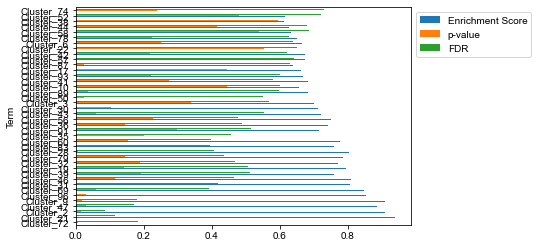

term is: Cluster_28
Cluster_29
Length of genes:6


2022-06-29 03:50:57,433 Parsing data files for GSEA.............................
2022-06-29 03:50:57,483 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:50:57,485 0099 gene_sets used for further statistical testing.....
2022-06-29 03:50:57,487 Start to run GSEA...Might take a while..................
2022-06-29 03:51:02,250 Start to generate gseapy reports, and produce figures...
2022-06-29 03:51:18,223 Congratulations. GSEApy runs successfully................



Cluster_29 is regulated:True


<Figure size 576x1080 with 0 Axes>

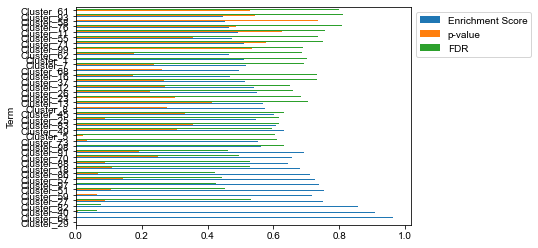

term is: Cluster_29
Cluster_30
Length of genes:7


2022-06-29 03:52:13,956 Parsing data files for GSEA.............................
2022-06-29 03:52:14,022 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:52:14,025 0099 gene_sets used for further statistical testing.....
2022-06-29 03:52:14,027 Start to run GSEA...Might take a while..................
2022-06-29 03:52:19,196 Start to generate gseapy reports, and produce figures...
2022-06-29 03:52:35,980 Congratulations. GSEApy runs successfully................



Cluster_30 is regulated:False


<Figure size 576x1080 with 0 Axes>

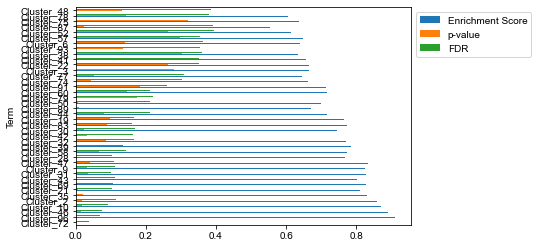

term is: Cluster_30
Cluster_31
Length of genes:4


2022-06-29 03:53:34,421 Parsing data files for GSEA.............................
2022-06-29 03:53:34,471 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:53:34,473 0099 gene_sets used for further statistical testing.....
2022-06-29 03:53:34,478 Start to run GSEA...Might take a while..................
2022-06-29 03:53:44,352 Start to generate gseapy reports, and produce figures...
2022-06-29 03:54:02,704 Congratulations. GSEApy runs successfully................



Cluster_31 is regulated:False


<Figure size 576x1080 with 0 Axes>

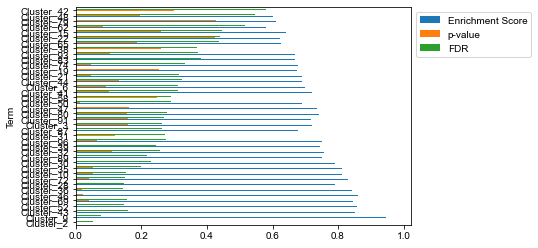

term is: Cluster_31
Cluster_32
Length of genes:4


2022-06-29 03:55:02,066 Parsing data files for GSEA.............................
2022-06-29 03:55:02,156 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:55:02,159 0099 gene_sets used for further statistical testing.....
2022-06-29 03:55:02,161 Start to run GSEA...Might take a while..................
2022-06-29 03:55:12,751 Start to generate gseapy reports, and produce figures...
2022-06-29 03:55:31,636 Congratulations. GSEApy runs successfully................



Cluster_32 is regulated:False


<Figure size 576x1080 with 0 Axes>

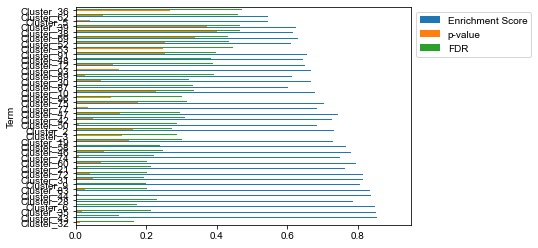

term is: Cluster_32
Cluster_33
Length of genes:4


2022-06-29 03:56:31,668 Parsing data files for GSEA.............................
2022-06-29 03:56:31,720 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:56:31,722 0099 gene_sets used for further statistical testing.....
2022-06-29 03:56:31,724 Start to run GSEA...Might take a while..................
2022-06-29 03:56:37,627 Start to generate gseapy reports, and produce figures...
2022-06-29 03:56:54,893 Congratulations. GSEApy runs successfully................



Cluster_33 is regulated:True


<Figure size 576x1080 with 0 Axes>

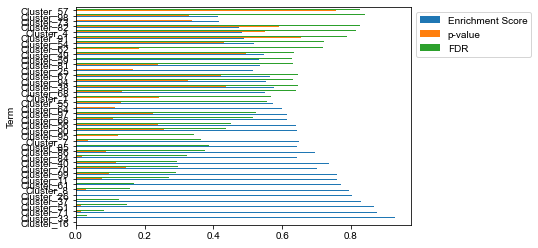

term is: Cluster_33
Cluster_34
Length of genes:8


2022-06-29 03:57:55,697 Parsing data files for GSEA.............................
2022-06-29 03:57:55,762 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:57:55,765 0099 gene_sets used for further statistical testing.....
2022-06-29 03:57:55,767 Start to run GSEA...Might take a while..................
2022-06-29 03:58:02,517 Start to generate gseapy reports, and produce figures...
2022-06-29 03:58:19,573 Congratulations. GSEApy runs successfully................



Cluster_34 is regulated:True


<Figure size 576x1080 with 0 Axes>

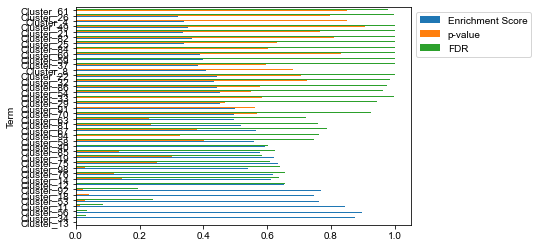

term is: Cluster_34
Cluster_35
Length of genes:4


2022-06-29 03:59:19,671 Parsing data files for GSEA.............................
2022-06-29 03:59:19,720 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 03:59:19,722 0099 gene_sets used for further statistical testing.....
2022-06-29 03:59:19,723 Start to run GSEA...Might take a while..................
2022-06-29 03:59:25,962 Start to generate gseapy reports, and produce figures...
2022-06-29 03:59:44,933 Congratulations. GSEApy runs successfully................



Cluster_35 is regulated:False


<Figure size 576x1080 with 0 Axes>

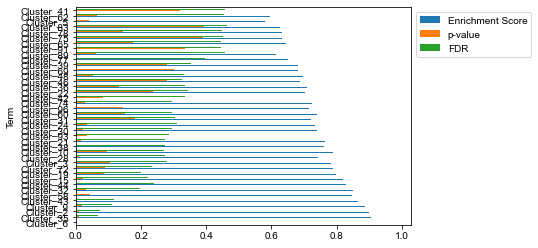

term is: Cluster_35
Cluster_36
Length of genes:5


2022-06-29 04:00:44,854 Parsing data files for GSEA.............................
2022-06-29 04:00:44,933 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:00:44,935 0099 gene_sets used for further statistical testing.....
2022-06-29 04:00:44,937 Start to run GSEA...Might take a while..................
2022-06-29 04:00:53,687 Start to generate gseapy reports, and produce figures...
2022-06-29 04:01:11,943 Congratulations. GSEApy runs successfully................



Cluster_36 is regulated:False


<Figure size 576x1080 with 0 Axes>

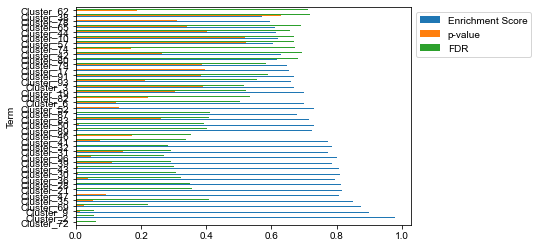

term is: Cluster_36
Cluster_37
Length of genes:7


2022-06-29 04:02:13,051 Parsing data files for GSEA.............................
2022-06-29 04:02:13,108 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:02:13,111 0099 gene_sets used for further statistical testing.....
2022-06-29 04:02:13,117 Start to run GSEA...Might take a while..................
2022-06-29 04:02:19,672 Start to generate gseapy reports, and produce figures...
2022-06-29 04:02:38,711 Congratulations. GSEApy runs successfully................



Cluster_37 is regulated:False


<Figure size 576x1080 with 0 Axes>

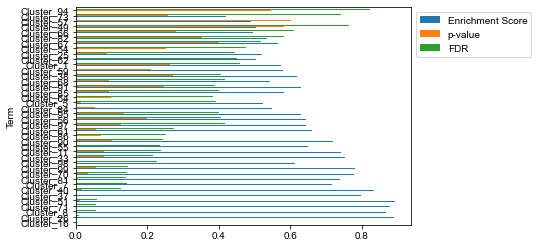

term is: Cluster_37
Cluster_38
Length of genes:4


2022-06-29 04:03:37,130 Parsing data files for GSEA.............................
2022-06-29 04:03:37,195 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:03:37,198 0099 gene_sets used for further statistical testing.....
2022-06-29 04:03:37,200 Start to run GSEA...Might take a while..................
2022-06-29 04:03:49,114 Start to generate gseapy reports, and produce figures...
2022-06-29 04:04:06,290 Congratulations. GSEApy runs successfully................



Cluster_38 is regulated:False


<Figure size 576x1080 with 0 Axes>

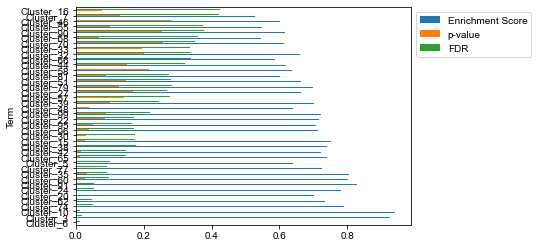

term is: Cluster_38
Cluster_39
Length of genes:4


2022-06-29 04:05:05,482 Parsing data files for GSEA.............................
2022-06-29 04:05:05,537 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:05:05,539 0099 gene_sets used for further statistical testing.....
2022-06-29 04:05:05,543 Start to run GSEA...Might take a while..................
2022-06-29 04:05:13,657 Start to generate gseapy reports, and produce figures...
2022-06-29 04:05:31,878 Congratulations. GSEApy runs successfully................



Cluster_39 is regulated:False


<Figure size 576x1080 with 0 Axes>

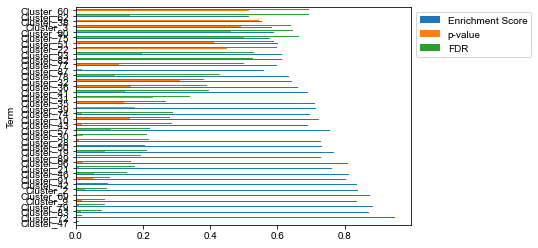

term is: Cluster_39
Cluster_40
Length of genes:4


2022-06-29 04:06:36,183 Parsing data files for GSEA.............................
2022-06-29 04:06:36,235 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:06:36,238 0099 gene_sets used for further statistical testing.....
2022-06-29 04:06:36,240 Start to run GSEA...Might take a while..................
2022-06-29 04:06:49,110 Start to generate gseapy reports, and produce figures...
2022-06-29 04:07:06,061 Congratulations. GSEApy runs successfully................



Cluster_40 is regulated:True


<Figure size 576x1080 with 0 Axes>

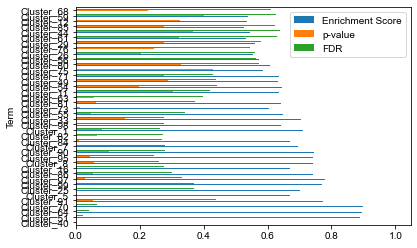

term is: Cluster_40
Cluster_41
Length of genes:5


2022-06-29 04:08:05,846 Parsing data files for GSEA.............................
2022-06-29 04:08:05,895 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:08:05,897 0099 gene_sets used for further statistical testing.....
2022-06-29 04:08:05,899 Start to run GSEA...Might take a while..................
2022-06-29 04:08:17,920 Start to generate gseapy reports, and produce figures...
2022-06-29 04:08:36,038 Congratulations. GSEApy runs successfully................



Cluster_41 is regulated:False


<Figure size 576x1080 with 0 Axes>

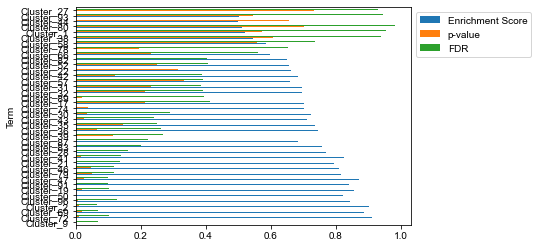

term is: Cluster_41
Cluster_42
Length of genes:6


2022-06-29 04:09:35,987 Parsing data files for GSEA.............................
2022-06-29 04:09:36,034 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:09:36,036 0099 gene_sets used for further statistical testing.....
2022-06-29 04:09:36,038 Start to run GSEA...Might take a while..................
2022-06-29 04:09:47,509 Start to generate gseapy reports, and produce figures...
2022-06-29 04:10:03,577 Congratulations. GSEApy runs successfully................



Cluster_42 is regulated:False


<Figure size 576x1080 with 0 Axes>

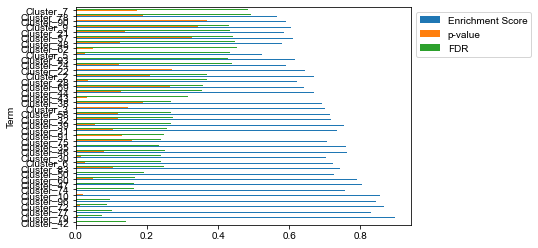

term is: Cluster_42
Cluster_43
Length of genes:8


2022-06-29 04:11:04,136 Parsing data files for GSEA.............................
2022-06-29 04:11:04,183 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:11:04,187 0099 gene_sets used for further statistical testing.....
2022-06-29 04:11:04,190 Start to run GSEA...Might take a while..................
2022-06-29 04:11:15,095 Start to generate gseapy reports, and produce figures...
2022-06-29 04:11:31,580 Congratulations. GSEApy runs successfully................



Cluster_43 is regulated:False


<Figure size 576x1080 with 0 Axes>

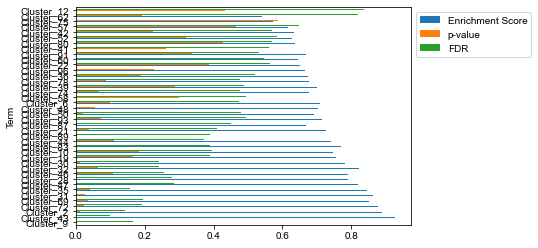

term is: Cluster_43
Cluster_44
Length of genes:5


2022-06-29 04:12:31,508 Parsing data files for GSEA.............................
2022-06-29 04:12:31,589 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:12:31,591 0099 gene_sets used for further statistical testing.....
2022-06-29 04:12:31,594 Start to run GSEA...Might take a while..................
2022-06-29 04:12:46,798 Start to generate gseapy reports, and produce figures...
2022-06-29 04:13:03,408 Congratulations. GSEApy runs successfully................



Cluster_44 is regulated:True


<Figure size 576x1080 with 0 Axes>

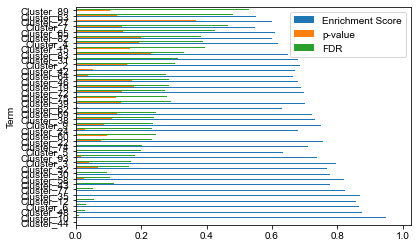

term is: Cluster_44
Cluster_45
Length of genes:4


2022-06-29 04:14:03,160 Parsing data files for GSEA.............................
2022-06-29 04:14:03,209 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:14:03,211 0099 gene_sets used for further statistical testing.....
2022-06-29 04:14:03,213 Start to run GSEA...Might take a while..................
2022-06-29 04:14:14,997 Start to generate gseapy reports, and produce figures...
2022-06-29 04:14:30,793 Congratulations. GSEApy runs successfully................



Cluster_45 is regulated:True


<Figure size 576x1080 with 0 Axes>

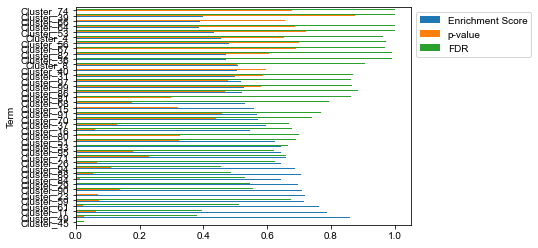

term is: Cluster_45
Cluster_46
Length of genes:4


2022-06-29 04:15:30,844 Parsing data files for GSEA.............................
2022-06-29 04:15:30,932 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:15:30,936 0099 gene_sets used for further statistical testing.....
2022-06-29 04:15:30,939 Start to run GSEA...Might take a while..................
2022-06-29 04:15:39,977 Start to generate gseapy reports, and produce figures...
2022-06-29 04:15:57,461 Congratulations. GSEApy runs successfully................



Cluster_46 is regulated:False


<Figure size 576x1080 with 0 Axes>

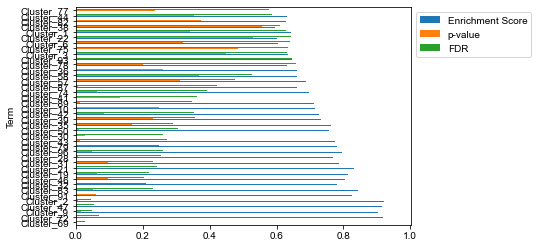

term is: Cluster_46
Cluster_47
Length of genes:4


2022-06-29 04:16:58,641 Parsing data files for GSEA.............................
2022-06-29 04:16:58,720 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:16:58,723 0099 gene_sets used for further statistical testing.....
2022-06-29 04:16:58,725 Start to run GSEA...Might take a while..................
2022-06-29 04:17:08,852 Start to generate gseapy reports, and produce figures...
2022-06-29 04:17:25,121 Congratulations. GSEApy runs successfully................



Cluster_47 is regulated:False


<Figure size 576x1080 with 0 Axes>

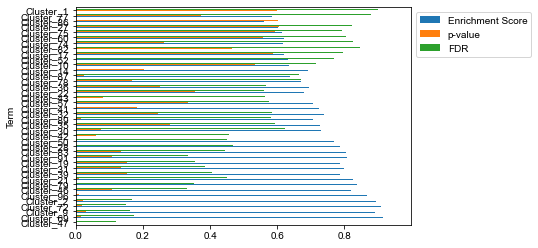

term is: Cluster_47
Cluster_48
Length of genes:7


2022-06-29 04:18:24,006 Parsing data files for GSEA.............................
2022-06-29 04:18:24,085 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:18:24,088 0099 gene_sets used for further statistical testing.....
2022-06-29 04:18:24,090 Start to run GSEA...Might take a while..................
2022-06-29 04:18:37,836 Start to generate gseapy reports, and produce figures...
2022-06-29 04:18:53,839 Congratulations. GSEApy runs successfully................



Cluster_48 is regulated:True


<Figure size 576x1080 with 0 Axes>

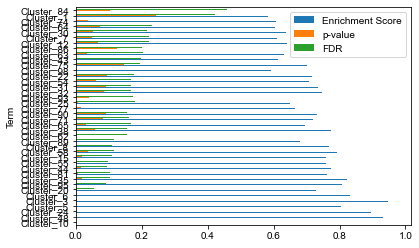

term is: Cluster_48
Cluster_49
Length of genes:4


2022-06-29 04:19:53,208 Parsing data files for GSEA.............................
2022-06-29 04:19:53,283 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:19:53,286 0099 gene_sets used for further statistical testing.....
2022-06-29 04:19:53,289 Start to run GSEA...Might take a while..................
2022-06-29 04:20:07,468 Start to generate gseapy reports, and produce figures...
2022-06-29 04:20:22,764 Congratulations. GSEApy runs successfully................



Cluster_49 is regulated:False


<Figure size 576x1080 with 0 Axes>

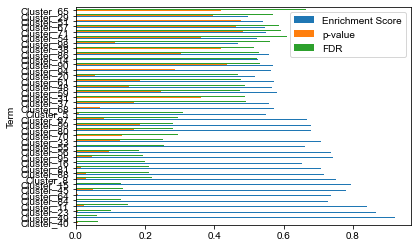

term is: Cluster_49
Cluster_50
Length of genes:10


2022-06-29 04:21:20,361 Parsing data files for GSEA.............................
2022-06-29 04:21:20,443 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:21:20,446 0099 gene_sets used for further statistical testing.....
2022-06-29 04:21:20,449 Start to run GSEA...Might take a while..................
2022-06-29 04:21:30,266 Start to generate gseapy reports, and produce figures...
2022-06-29 04:21:47,071 Congratulations. GSEApy runs successfully................



Cluster_50 is regulated:False


<Figure size 576x1080 with 0 Axes>

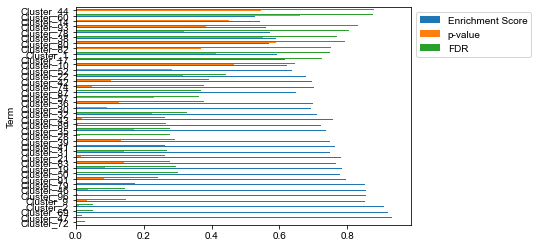

term is: Cluster_50
Cluster_51
Length of genes:4


2022-06-29 04:22:46,209 Parsing data files for GSEA.............................
2022-06-29 04:22:46,260 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:22:46,262 0099 gene_sets used for further statistical testing.....
2022-06-29 04:22:46,265 Start to run GSEA...Might take a while..................
2022-06-29 04:22:56,512 Start to generate gseapy reports, and produce figures...
2022-06-29 04:23:13,564 Congratulations. GSEApy runs successfully................



Cluster_51 is regulated:True


<Figure size 576x1080 with 0 Axes>

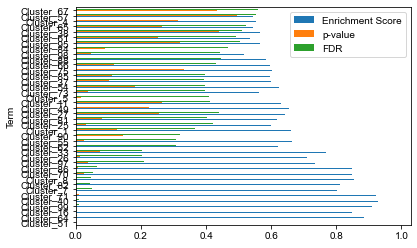

term is: Cluster_51
Cluster_52
Length of genes:5


2022-06-29 04:24:12,674 Parsing data files for GSEA.............................
2022-06-29 04:24:12,722 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:24:12,724 0099 gene_sets used for further statistical testing.....
2022-06-29 04:24:12,726 Start to run GSEA...Might take a while..................
2022-06-29 04:24:23,843 Start to generate gseapy reports, and produce figures...
2022-06-29 04:24:40,486 Congratulations. GSEApy runs successfully................



Cluster_52 is regulated:False


<Figure size 576x1080 with 0 Axes>

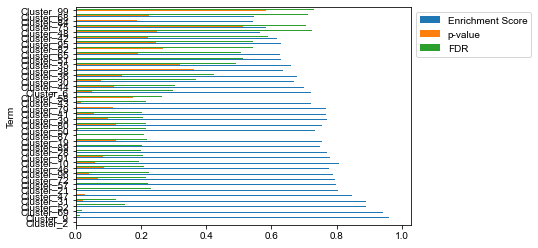

term is: Cluster_52
Cluster_53
Length of genes:5


2022-06-29 04:25:38,559 Parsing data files for GSEA.............................
2022-06-29 04:25:38,634 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:25:38,637 0099 gene_sets used for further statistical testing.....
2022-06-29 04:25:38,641 Start to run GSEA...Might take a while..................
2022-06-29 04:25:50,966 Start to generate gseapy reports, and produce figures...
2022-06-29 04:26:07,620 Congratulations. GSEApy runs successfully................



Cluster_53 is regulated:True


<Figure size 576x1080 with 0 Axes>

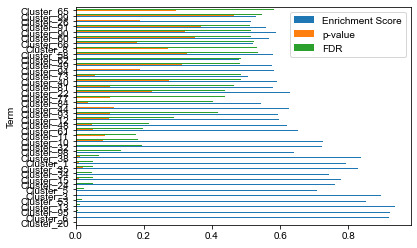

term is: Cluster_53
Cluster_54
Length of genes:5


2022-06-29 04:27:05,518 Parsing data files for GSEA.............................
2022-06-29 04:27:05,596 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:27:05,598 0099 gene_sets used for further statistical testing.....
2022-06-29 04:27:05,600 Start to run GSEA...Might take a while..................
2022-06-29 04:27:18,381 Start to generate gseapy reports, and produce figures...
2022-06-29 04:27:35,779 Congratulations. GSEApy runs successfully................



Cluster_54 is regulated:False


<Figure size 576x1080 with 0 Axes>

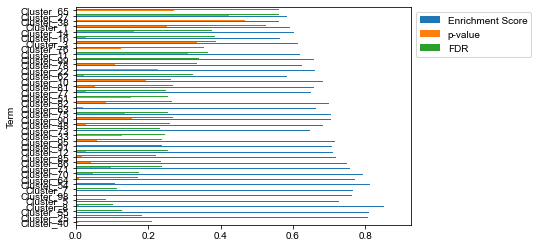

term is: Cluster_54
Cluster_55
Length of genes:8


2022-06-29 04:28:33,570 Parsing data files for GSEA.............................
2022-06-29 04:28:33,650 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:28:33,652 0099 gene_sets used for further statistical testing.....
2022-06-29 04:28:33,655 Start to run GSEA...Might take a while..................
2022-06-29 04:28:42,065 Start to generate gseapy reports, and produce figures...
2022-06-29 04:28:58,379 Congratulations. GSEApy runs successfully................



Cluster_55 is regulated:True


<Figure size 576x1080 with 0 Axes>

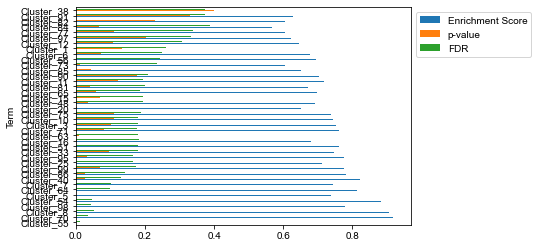

term is: Cluster_55
Cluster_56
Length of genes:4


2022-06-29 04:29:56,190 Parsing data files for GSEA.............................
2022-06-29 04:29:56,237 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:29:56,239 0099 gene_sets used for further statistical testing.....
2022-06-29 04:29:56,241 Start to run GSEA...Might take a while..................
2022-06-29 04:30:04,788 Start to generate gseapy reports, and produce figures...
2022-06-29 04:30:21,771 Congratulations. GSEApy runs successfully................



Cluster_56 is regulated:False


<Figure size 576x1080 with 0 Axes>

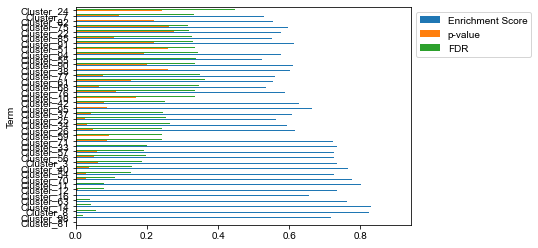

term is: Cluster_56
Cluster_57
Length of genes:4


2022-06-29 04:31:21,231 Parsing data files for GSEA.............................
2022-06-29 04:31:21,310 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:31:21,312 0099 gene_sets used for further statistical testing.....
2022-06-29 04:31:21,315 Start to run GSEA...Might take a while..................
2022-06-29 04:31:31,325 Start to generate gseapy reports, and produce figures...
2022-06-29 04:31:49,416 Congratulations. GSEApy runs successfully................



Cluster_57 is regulated:False


<Figure size 576x1080 with 0 Axes>

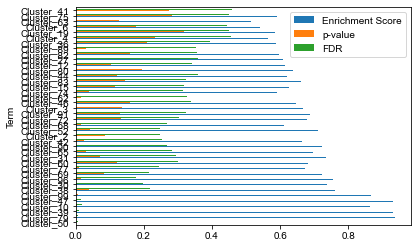

term is: Cluster_57
Cluster_58
Length of genes:5


2022-06-29 04:32:46,646 Parsing data files for GSEA.............................
2022-06-29 04:32:46,692 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:32:46,694 0099 gene_sets used for further statistical testing.....
2022-06-29 04:32:46,696 Start to run GSEA...Might take a while..................
2022-06-29 04:33:01,366 Start to generate gseapy reports, and produce figures...
2022-06-29 04:33:20,504 Congratulations. GSEApy runs successfully................



Cluster_58 is regulated:False


<Figure size 576x1080 with 0 Axes>

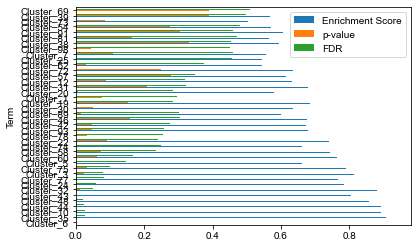

term is: Cluster_58
Cluster_59
Length of genes:5


2022-06-29 04:34:19,449 Parsing data files for GSEA.............................
2022-06-29 04:34:19,559 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:34:19,562 0099 gene_sets used for further statistical testing.....
2022-06-29 04:34:19,564 Start to run GSEA...Might take a while..................
2022-06-29 04:34:34,136 Start to generate gseapy reports, and produce figures...
2022-06-29 04:34:51,313 Congratulations. GSEApy runs successfully................



Cluster_59 is regulated:False


<Figure size 576x1080 with 0 Axes>

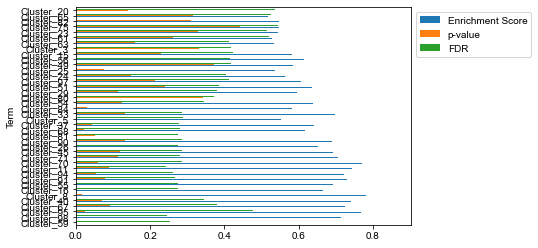

term is: Cluster_59
Cluster_60
Length of genes:4


2022-06-29 04:35:50,137 Parsing data files for GSEA.............................
2022-06-29 04:35:50,202 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:35:50,204 0099 gene_sets used for further statistical testing.....
2022-06-29 04:35:50,206 Start to run GSEA...Might take a while..................
2022-06-29 04:36:00,157 Start to generate gseapy reports, and produce figures...
2022-06-29 04:36:18,568 Congratulations. GSEApy runs successfully................



Cluster_60 is regulated:False


<Figure size 576x1080 with 0 Axes>

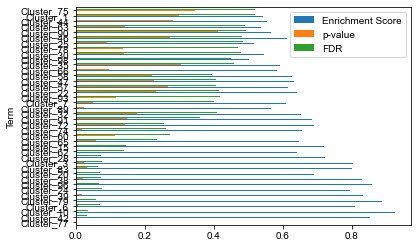

term is: Cluster_60
Cluster_61
Length of genes:6


2022-06-29 04:37:17,862 Parsing data files for GSEA.............................
2022-06-29 04:37:17,912 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:37:17,914 0099 gene_sets used for further statistical testing.....
2022-06-29 04:37:17,916 Start to run GSEA...Might take a while..................
2022-06-29 04:37:27,862 Start to generate gseapy reports, and produce figures...
2022-06-29 04:37:46,404 Congratulations. GSEApy runs successfully................



Cluster_61 is regulated:False


<Figure size 576x1080 with 0 Axes>

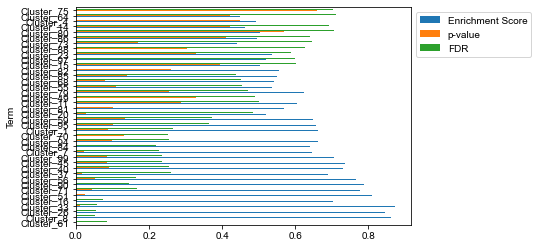

term is: Cluster_61
Cluster_62
Length of genes:13


2022-06-29 04:38:44,354 Parsing data files for GSEA.............................
2022-06-29 04:38:44,425 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:38:44,430 0099 gene_sets used for further statistical testing.....
2022-06-29 04:38:44,440 Start to run GSEA...Might take a while..................
2022-06-29 04:38:53,219 Start to generate gseapy reports, and produce figures...
2022-06-29 04:39:11,257 Congratulations. GSEApy runs successfully................



Cluster_62 is regulated:True


<Figure size 576x1080 with 0 Axes>

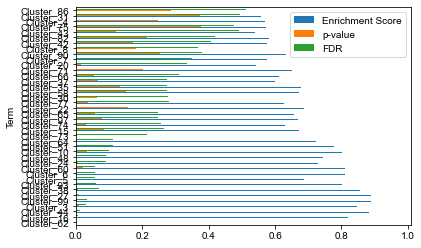

term is: Cluster_62
Cluster_63
Length of genes:8


2022-06-29 04:40:11,274 Parsing data files for GSEA.............................
2022-06-29 04:40:11,402 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:40:11,405 0099 gene_sets used for further statistical testing.....
2022-06-29 04:40:11,409 Start to run GSEA...Might take a while..................
2022-06-29 04:40:20,461 Start to generate gseapy reports, and produce figures...
2022-06-29 04:40:36,940 Congratulations. GSEApy runs successfully................



Cluster_63 is regulated:True


<Figure size 576x1080 with 0 Axes>

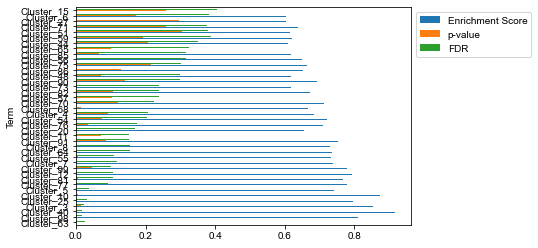

term is: Cluster_63
Cluster_64
Length of genes:7


2022-06-29 04:41:37,066 Parsing data files for GSEA.............................
2022-06-29 04:41:37,165 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:41:37,168 0099 gene_sets used for further statistical testing.....
2022-06-29 04:41:37,170 Start to run GSEA...Might take a while..................
2022-06-29 04:41:46,962 Start to generate gseapy reports, and produce figures...
2022-06-29 04:42:04,717 Congratulations. GSEApy runs successfully................



Cluster_64 is regulated:True


<Figure size 576x1080 with 0 Axes>

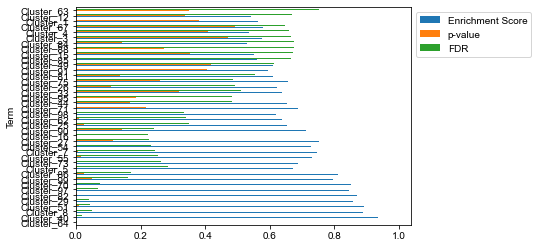

term is: Cluster_64
Cluster_65
Length of genes:6


2022-06-29 04:42:59,931 Parsing data files for GSEA.............................
2022-06-29 04:42:59,998 0001 gene_sets have been filtered out when max_size=500 and min_size=2
2022-06-29 04:43:00,001 0099 gene_sets used for further statistical testing.....
2022-06-29 04:43:00,003 Start to run GSEA...Might take a while..................
2022-06-29 04:43:07,518 Start to generate gseapy reports, and produce figures...
2022-06-29 04:43:23,046 Congratulations. GSEApy runs successfully................



Cluster_65 is regulated:True


<Figure size 576x1080 with 0 Axes>

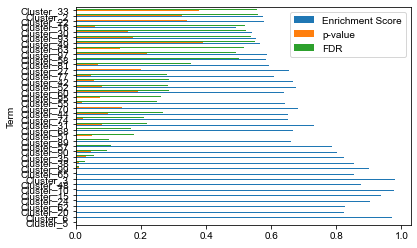

term is: Cluster_65
Cluster_66
Length of genes:7


In [ ]:
New_df4 = pd.DataFrame([])
Final_gsea=pd.DataFrame([])
# count=1
for pathway in Pathway_df4.index:
#     pathway = 'Cluster_8';
#     count=count+1
    print(pathway)
#     pathway = 'ALA_ASP_AND_GLU_METABOLISM';
    genes = list(Pathway_df4.loc[pathway].dropna());
    file_exist = False;
    for file in os.listdir(output_dir):
        if fnmatch.fnmatch(file, "Pathway_self_enrichment_{}.csv".format(pathway)):
            print("File: {} found, skipping!!!".format(file))
            file_exist = True;
    if(not file_exist):
        pre_res = PreRank(genes=genes, outdir="{}/{}".format(output_dir,pathway),gene_sets=pathway_filename4);
        if(pre_res is None):
            continue; 
        Pathway_df4.at[pathway, 'IsRegulated'] = _is_regulated_pathway_(pre_res, pathway);
        print("{} is regulated:{}".format(pathway,_is_regulated_pathway_(pre_res, pathway)))
        PlotEnrichment(pre_res, pathway,"./{}".format(pathway))
        if(pathway in pre_res.res2d.index):
            PlotGSEA(pre_res, pathway,outdir="./{}".format(pathway),term=pathway)
            gsea_result_df=pre_res.res2d.loc[pathway];
            gsea_result_df=pd.DataFrame(gsea_result_df)
            gsea_result_df.to_csv("Pathway_self_enrichment_{}.csv".format(pathway))
            gsea_result_df=gsea_result_df.transpose()
#             gsea_result_df['Pathway_Main']=pathway
            New_df4=New_df4.append(gsea_result_df)
#             New_df4.at[pathway,'Pathway_main']=pathway
#             New_df4.to_csv("{}/Pathway_{}.csv".format(output_dir,pathway))
#         if count>2:
#     break;
# Pathway_df4.to_csv("Pathway_Regulation_status4.csv")
# New_df4.to_csv("{}/Final_pathway4_gsea.csv".format(output_dir))


In [44]:
Pathway_df4[0:40]

,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,Gene_10,Gene_11,Gene_12,Gene_13,Gene_14,Gene_15,Gene_16,Gene_17,Gene_18,IsRegulated
ClusterName,,,,,,,,,,,,,,,,,,,
Cluster_1,pgph-3,pgph-2,F41E6.5,pgph-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
Cluster_2,pdhb-1,dlat-1,pdha-1,dld-1,dlat-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
Cluster_3,Y51H4A.7,cpin-1,haly-1,amdh-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
Cluster_4,gln-6,T03F6.3,gln-5,gfat-2,gfat-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
Cluster_5,nduo-6,nduo-3,nduo-2,ndfl-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
Cluster_6,vha-9,vha-8,vha-14,vha-17,vha-10,vha-1,vha-4,vha-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
Cluster_7,T20B3.1,daf-22,ech-8,F53C11.3,B0272.4,dhs-28,acox-1.1,acox-3,maoc-1,F58A6.1,ech-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
Cluster_8,cyp-35A5,cyp-35A1,cyp-35A2,cyp-35A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
Cluster_9,argk-1,W10C8.5,ZC434.8,F32B5.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [43]:
x=pd.read_csv("Pathway_self_enrichment_Cluster_8.csv",index_col=0)

In [44]:
x

,Cluster_8
es,0.984006397441023
nes,2.4911787314542364
pval,0.0
fdr,0.0
geneset_size,4
matched_size,4
genes,Y51H4A.7;haly-1;amdh-1;cpin-1
ledge_genes,Y51H4A.7;haly-1;amdh-1;cpin-1


In [47]:
# New_df4=pd.read_csv("{}/Final_pathway4_gsea.csv".format(output_dir),index_col=0)

In [48]:
# New_df4.index=New_df4.index.str.replace("_"," ")

In [49]:
# New_df4.index=New_df4.index.str.title()

In [50]:
New_df4.to_csv("Final_pathway4_gsea.csv")

In [51]:
New_df4

""


In [52]:
Pathway_df4=Pathway_df4['IsRegulated']

In [53]:
Pathway_df4=pd.DataFrame(Pathway_df4)

In [54]:
Regulated=Pathway_df4[Pathway_df4['IsRegulated']==True]

In [55]:
NotRegulated=Pathway_df4[Pathway_df4['IsRegulated']!=True]

In [56]:
Enrichment=pd.read_csv("{}/Final_pathway4_gsea.csv".format(output_dir),index_col=0)

In [57]:
Regulated

,IsRegulated
ClusterName,


In [58]:
SelectedClusters=pd.read_csv("/data/nandas/Coflux_matrix/FluxRed_102220/Product_Matrix_063021/ProductMatrix_SelectedClusterSets_063021.gmt",
                            sep='\t',index_col=0)

In [59]:
for i in SelectedClusters.index:
    SelectedClusters.at[i,'ClusterNumber']="Cluster_{}".format(i)

In [60]:
SelectedClusters.set_index(['ClusterNumber'],inplace=True)

In [61]:
intersect=list(set(Regulated.index).intersection(set(SelectedClusters.index)))

In [62]:
RegulatedSelectedClusters=SelectedClusters.loc[intersect]

In [63]:
RegulatedSelectedClusters

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,Mean Silhouette Values
ClusterNumber,,,,,,,,,,,,,,,,,,,,,


In [64]:
Enrichment_result=New_df4[['es','nes','fdr']]

KeyError: "None of [Index(['es', 'nes', 'fdr'], dtype='object')] are in the [columns]"

In [ ]:
Enrichment_result=Enrichment_result[Enrichment_result.fdr<=0.05]

In [ ]:
Enrichment_result.sort_values(by=['fdr'],inplace=True,ascending=False)

In [ ]:
Enrichment_result.rename(columns={'es':'Enrichment Score','nes':'Normalized Enrichment Score','fdr':'FDR'},inplace=True)

In [ ]:
ax=plt.figure(figsize=(40,180))
plt.rcParams["font.family"] = "Arial"
# Enrichment_result=pd.DataFrame({'es':'Enrichment Score','nes':'Normalized Enrichment Score','fdr':'FDR'},index=Enrichment_result.index)
Enrichment_result.plot.barh()
plt.savefig("EnrichmentPlot.svg",dpi=300,format='svg')
plt.show()

In [ ]:
Enrichment_result.shape

In [ ]:
def Pathway_Enrichment_Of_Regulated_Genes(Base_dir,Pathway_df4,level):
    path =Base_dir
    print(path)
    dfs = []
    for x in Pathway_df4.index:
        files='{}/Pathway_{}.csv'.format(path,x)
        df=pd.read_csv(files)
        df['Pathway_main']=x;
#         df['Class']=RegulatedMetabolic.loc[x]['Class']
        df.set_index(['Pathway_main'],inplace=True)
        df.to_csv(files)
        print(files)
        dfs.append(pd.read_csv(files))

    # # Concatenate all data into one DataFrame

    All_TFs = pd.concat(dfs, ignore_index=False)
    # # Filtering out negative or not applicable enrichment¶
    All_TFs=All_TFs[All_TFs.nes!=np.inf]
    All_TFs=All_TFs[All_TFs.nes>=0]
    All_TFs.to_csv("Combined_TF_Pathway_Enrichement_{}.csv".format(level))
    return dfs,All_TFs

In [ ]:
df4,All_TFs4=Pathway_Enrichment_Of_Regulated_Genes(Base_dir=".",Pathway_df4=Pathway_df4,level='Level_4')

In [ ]:
New_df4=pd.read_csv("Combined_TF_Pathway_Enrichement_Level_4.csv",index_col=0)

In [ ]:
# New_df4.reset_index(inplace=True)
Significant_Pathways4=New_df4[New_df4.fdr<=0.05]
Significant_Pathways4=Significant_Pathways4[Significant_Pathways4.nes>2]
Significant_Pathways4=Significant_Pathways4[['Pathway_main','Term','fdr']]

In [ ]:
# Significant_Pathways4['fdr']=1-(Significant_Pathways4.fdr)

In [ ]:
Significant_Pathways4.sort_values(by=['fdr'],ascending=True)

In [ ]:
def ConvertPairsToMatrix(bayesian_metabol_df):
    a = np.unique(bayesian_metabol_df['Pathway_main'])
    b = np.unique(bayesian_metabol_df['Term'])
#     c = np.union1d(a,b);
    data = np.zeros((len(a), len(b)));
    output_df = pd.DataFrame(data, index=a, columns=b)
    for values in bayesian_metabol_df.values: 
        output_df.loc[values[0]][values[1]] = values[2];
#         output_df[values[1]][values[0]]=values[2];
#     np.fill_diagonal(output_df.values,1)
    return output_df

In [ ]:
Significant_PathwaysMatrix4=ConvertPairsToMatrix(Significant_Pathways4)
Significant_PathwaysMatrix4=Significant_PathwaysMatrix4.transpose()

In [ ]:
len(np.unique(Significant_Pathways4['Pathway_main']))

In [ ]:
Significant_PathwaysMatrix4=Significant_PathwaysMatrix4.loc[Significant_PathwaysMatrix4.sum(axis=1)!=0]
#     Significant_PathwaysMatrix2=Significant_PathwaysMatrix2.loc[(Significant_PathwaysMatrix2.sum(axis=1)!=0).index]
# #     Significant_PathwaysMatrix2=Significant_PathwaysMatrix2.loc[Significant_PathwaysMatrix2.index.str.contains('nhr')==True]
# #     Significant_PathwaysMatrix2=Significant_PathwaysMatrix2[(Significant_PathwaysMatrix2.sum()!=0).index]
Significant_PathwaysMatrix4=Significant_PathwaysMatrix4.transpose()
# #     print(Significant_PathwaysMatrix2.shape)
#     Significant_PathwaysMatrix2=Significant_PathwaysMatrix2.loc[(Significant_PathwaysMatrix2.sum()!=0).index]
# #     Significant_PathwaysMatrix2.drop(index=Categories,inplace=True)
# #     print(Significant_PathwaysMatrix2.shape)
# # # Pathways1.set_index(['Gene'],inplace=True)
sns.clustermap(Significant_PathwaysMatrix4,figsize=(28, 28),method='average',cbar_kws={'label':'FDR'},col_cluster=True,
                  yticklabels=True,xticklabels=True)
plt.savefig("PathwayCluster_Leve4.png")

In [ ]:
Significant_Pathways4

In [ ]:
Significant_PathwaysMatrix4=0.05-Significant_PathwaysMatrix4

In [ ]:
Significant_PathwaysMatrix4

In [ ]:
status1=Pathway_df1['IsRegulated']
status1=pd.DataFrame(status1)
status2=Pathway_df1['IsRegulated']
status2=pd.DataFrame(status2)
status3=Pathway_df3['IsRegulated']
status3=pd.DataFrame(status3)
status4=Pathway_df4['IsRegulated']
status4=pd.DataFrame(status4)

In [ ]:
status1.to_csv("Pathway_Regulation_status1.csv")
status2.to_csv("Pathway_Regulation_status2.csv")
status3.to_csv("Pathway_Regulation_status3.csv")
status4.to_csv("Pathway_Regulation_status4.csv")

In [ ]:
status1=pd.read_csv("Pathway_Regulation_status1.csv",index_col=0)
status2=pd.read_csv("Pathway_Regulation_status2.csv",index_col=0)
status3=pd.read_csv("Pathway_Regulation_status3.csv",index_col=0)
status4=pd.read_csv("Pathway_Regulation_status4.csv",index_col=0)

In [ ]:
status1.IsRegulated.groupby(status1.IsRegulated).count()
status2.IsRegulated.groupby(status2.IsRegulated).count()
status3.IsRegulated.groupby(status3.IsRegulated).count()
status4.IsRegulated.groupby(status4.IsRegulated).count()

In [ ]:
#Status_1
my_labels='Non-Regulated','Regulated'
sums1 = status1.IsRegulated.groupby(status1.IsRegulated).count()
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

#Status_2
my_labels='Non-Regulated','Regulated'
sums2 = status2.IsRegulated.groupby(status2.IsRegulated).count()
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

#Status_3
my_labels='Non-Regulated','Regulated'
sums3 = status3.IsRegulated.groupby(status3.IsRegulated).count()
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct



In [ ]:
#Status_4
my_labels='Non-Regulated','Regulated'
sums4 = status4.IsRegulated.groupby(status4.IsRegulated).count()
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

In [ ]:
sums4

In [ ]:
# Level_1
fig, ax = plt.subplots(figsize=(12,10))
size = 0.3
plt.pie(sums1,labels=my_labels,autopct=make_autopct(sums1))
plt.savefig("Overall_result_piechart_level_1.png")
plt.show()


In [ ]:
# Level_2
fig, ax = plt.subplots(figsize=(12,10))
size = 0.3
plt.pie(sums2,labels=my_labels,autopct=make_autopct(sums2))
plt.savefig("Overall_result_piechart_level_2.png")


In [ ]:
# Level 3
fig, ax = plt.subplots(figsize=(12,10))
size = 0.3
plt.pie(sums3,labels=my_labels,autopct=make_autopct(sums3))
plt.savefig("Overall_result_piechart_level_3.png")


In [ ]:
# Level 4
fig, ax = plt.subplots(figsize=(12,10))
size = 0.3
plt.pie(sums4,labels=my_labels,autopct=make_autopct(sums4))
plt.savefig("Overall_result_piechart_level_4.png")
